## Initial imports

In [1]:
from typing import List
import scm.plams as plams
from scm.input_classes import engines
from scm.reactions_discovery import ReactionsDiscoveryJob
from rdkit import Chem
from rdkit.Chem import Draw

# Settings for displaying molecules in the notebook
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 250, 250

# this line is not required in AMS2025+
plams.init()

PLAMS working folder: /path/plams/examples/ReactionsDiscovery/plams_workdir.002


## Helpers for showing molecules

In [2]:
def draw_molecules(molecules: List[plams.Molecule]):
    smiles = [molecule.properties.smiles for molecule in molecules]
    return draw_smiles(smiles)


def draw_smiles(smiles: List[str]):
    rd_mols = [Chem.MolFromSmiles(s) for s in smiles]
    return Draw.MolsToGridImage(rd_mols)

## The ReactionsDiscoveryJob class

In [3]:
job = ReactionsDiscoveryJob(name="MyDiscovery")
driver = job.input
md = driver.MolecularDynamics

## Setting up the reactants for molecular dynamics

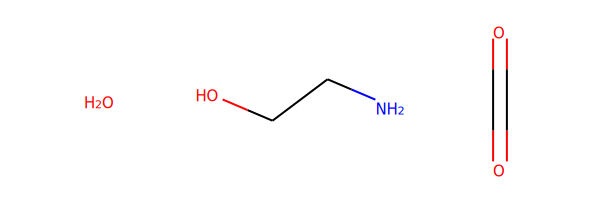

In [4]:
md.NumSimulations = 4
build = md.BuildSystem
build.NumAtoms = 250
build.Density = 0.9
build.Molecule[0].SMILES = "O"  # Water
build.Molecule[0].MoleFraction = 1
build.Molecule[1].SMILES = "NCCO"  # MEA
build.Molecule[1].MoleFraction = 2
build.Molecule[2].SMILES = "O=C=O"  # Carbondioxide
build.Molecule[2].MoleFraction = 3
draw_smiles([build.Molecule[i].SMILES.val for i in range(len(build.Molecule))])

## Setting up reactive molecular dynamics

In [5]:
md.Enabled = "Yes"
md.Type = "NanoReactor"
reactor = md.NanoReactor
reactor.NumCycles = 10
reactor.Temperature = 500
reactor.MinVolumeFraction = 0.6

## Setting up network extraction and ranking

In [6]:
network = driver.NetworkExtraction
network.Enabled = "Yes"
network.UseCharges = "Yes"
ranking = driver.ProductRanking
ranking.Enabled = "Yes"

## Selecting the AMS engine to use

In [7]:
engine = engines.ReaxFF()
engine.ForceField = "Glycine.ff"
engine.TaperBO = "Yes"  # This is a really important setting for reaction analysis with ReaxFF potentials
driver.Engine = engine

## Running reactions discovery

In [8]:
result = job.run()  # start the job
job.check()  # check if job was succesful

[11.02|09:43:46] JOB MyDiscovery STARTED
[11.02|09:43:46] JOB MyDiscovery RUNNING
[11.02|09:46:16] JOB MyDiscovery FINISHED
[11.02|09:46:17] JOB MyDiscovery SUCCESSFUL


True

## Obtain the results

In [9]:
graph, molecules, categories = result.get_network()

## Categories

The categories are `Products` `Reactants` and `Unstable`, as described in the reactions discovery manual. `molecules` is a dictionary with keys equal to the categories and each concomitant value is a list of PLAMS molecules.

In [10]:
print(categories)

['Reactants', 'Products', 'Unstable']


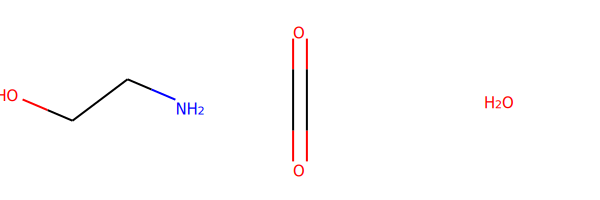

In [11]:
draw_molecules(molecules["Reactants"])

## Products

These are the side products that reactions discovery found in the order as found by the ranking algorithm.

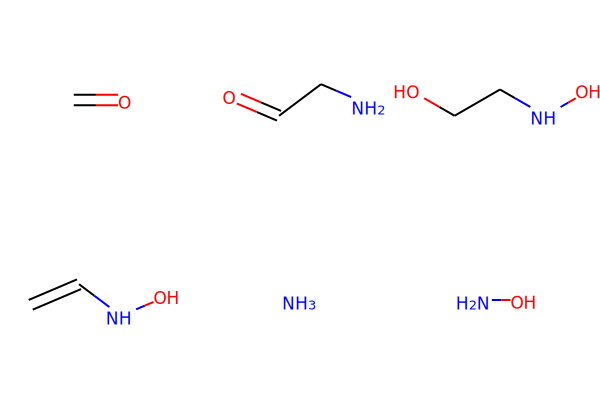

In [12]:
draw_molecules(molecules["Products"][:6])

## Unstable

Unstable products were determined to not likely exist outside of reactive dynamics. This e.g. includes radicals or structures that don't form stable molecules in isolation. Not all unstable molecules have a sensible 2d structure, so instead we plot their 3d structure.

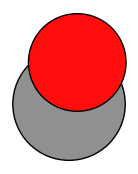

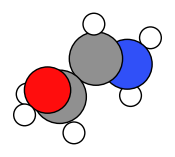

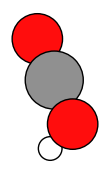

In [13]:
for unstable_molecule in molecules["Unstable"][:3]:
    plams.plot_molecule(unstable_molecule);

## Graph of the reaction network

The graph is a bipartate networkx DiGraph with reaction and molecule nodes. This can be stored on disk in standard graph formats, e.g. `.gml`

In [14]:
import networkx as nx

nx.write_gml(graph, "reaction_network.gml")

## Load a job not originally run by PLAMS

In [19]:
from scm.plams import FileError

try:
    job = ReactionsDiscoveryJob.load_external("plams_workdir/MyDiscovery")
    graph, molecules, categories = job.results.get_network()
except FileError:
    pass